<a href="https://colab.research.google.com/github/Flychuban/Tyres-Condition/blob/main/TyreCondition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import numpy as np
import glob
from pathlib import Path
import tensorflow as tf
import os
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D
from tensorflow.keras.callbacks import EarlyStopping

In [24]:
train_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/training_data')
test_path = Path('/content/drive/MyDrive/TyreConditionPrediction/data/Tire Textures/testing_data')
RANDOM_SEED = 10
EPOCHS = 50
BATCH_SIZE = 16

In [25]:
labels = os.listdir(train_path)
labels

['normal', 'cracked']

Let's make our dataset

In [26]:
def process_data(data):
  path = Path(data)
  filepaths = list(path.glob(r'*/*.jpg'))
  labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))#Separating the label from filepath and storing it
  df1 = pd.Series(filepaths, name='filepaths').astype(str)
  df2 = pd.Series(labels, name='labels')
  df = pd.concat([df1, df2], axis=1)
  return df

In [27]:
train_data = process_data(train_path)
test_data = process_data(test_path)
train_data

,filepaths,labels
0,/content/drive/MyDrive/TyreConditionPrediction...,normal
1,/content/drive/MyDrive/TyreConditionPrediction...,normal
2,/content/drive/MyDrive/TyreConditionPrediction...,normal
3,/content/drive/MyDrive/TyreConditionPrediction...,normal
4,/content/drive/MyDrive/TyreConditionPrediction...,normal
...,...,...
698,/content/drive/MyDrive/TyreConditionPrediction...,cracked
699,/content/drive/MyDrive/TyreConditionPrediction...,cracked
700,/content/drive/MyDrive/TyreConditionPrediction...,cracked
701,/content/drive/MyDrive/TyreConditionPrediction...,cracked


In [44]:
train_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                     rotation_range=20,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     horizontal_flip=True,
                                     vertical_flip=True)
test_generator = ImageDataGenerator(preprocessing_function=preprocess_input,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    validation_split=0.5)

In [45]:
train_images = train_generator.flow_from_dataframe(dataframe=train_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED)

test_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                 target_size=(224, 224),
                                                 batch_size=BATCH_SIZE,
                                                 x_col='filepaths',
                                                 y_col = 'labels',
                                                 class_mode='binary',
                                                 random_seed = RANDOM_SEED,
                                                 subset='training'
                                                 )

val_images = test_generator.flow_from_dataframe(dataframe=test_data,
                                                   target_size=(224, 224),
                                                   batch_size = BATCH_SIZE,
                                                   x_col='filepaths',
                                                   y_col='labels',
                                                   class_mode='binary',
                                                   random_seed=RANDOM_SEED,
                                                   subset="validation"
                                                )


Found 703 validated image filenames belonging to 2 classes.
Found 163 validated image filenames belonging to 2 classes.
Found 162 validated image filenames belonging to 2 classes.


Build the model

In [46]:
pretrained_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights = 'imagenet',
    pooling='max'
)

In [47]:
pretrained_model.trainable = False # we make this cuz w don't train again the big model

In [57]:
inputs = pretrained_model.input

new_layer = Dense(30, activation='relu')(pretrained_model.output)
Dropout(0.3)
new_layer = Dense(60, activation='relu')(new_layer)
Dropout(0.5)
new_layer = Dense(120, activation ='relu')(new_layer)

outputs = Dense(1, activation = 'softmax')(new_layer)

In [58]:
model = Model(inputs=inputs, outputs=outputs)

In [59]:

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy']
)

In [60]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)

Training

In [61]:
history = model.fit(train_images,
                    epochs=EPOCHS,
                    steps_per_epoch=len(train_images),
                    validation_data=val_images,
                    validation_steps=len(val_images),
                    callbacks=[early_stop]
                    )

Epoch 1/50
44/44 [==============================] - 233s 5s/step - loss: 0.4880 - accuracy: 0.5349 - val_loss: 0.4565 - val_accuracy: 0.7099
Epoch 2/50
44/44 [==============================] - 202s 5s/step - loss: 0.2526 - accuracy: 0.5349 - val_loss: 0.3885 - val_accuracy: 0.7099
Epoch 3/50
44/44 [==============================] - 243s 6s/step - loss: 0.2283 - accuracy: 0.5349 - val_loss: 0.3228 - val_accuracy: 0.7099
Epoch 4/50
44/44 [==============================] - 202s 5s/step - loss: 0.1852 - accuracy: 0.5349 - val_loss: 0.2831 - val_accuracy: 0.7099
Epoch 5/50
44/44 [==============================] - 200s 5s/step - loss: 0.1789 - accuracy: 0.5349 - val_loss: 0.2503 - val_accuracy: 0.7099
Epoch 6/50
44/44 [==============================] - 203s 5s/step - loss: 0.1902 - accuracy: 0.5349 - val_loss: 0.2631 - val_accuracy: 0.7099
Epoch 7/50
44/44 [==============================] - 239s 5s/step - loss: 0.1826 - accuracy: 0.5349 - val_loss: 0.3218 - val_accuracy: 0.7099


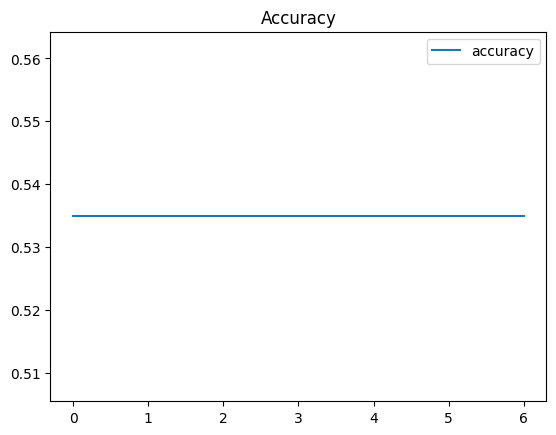

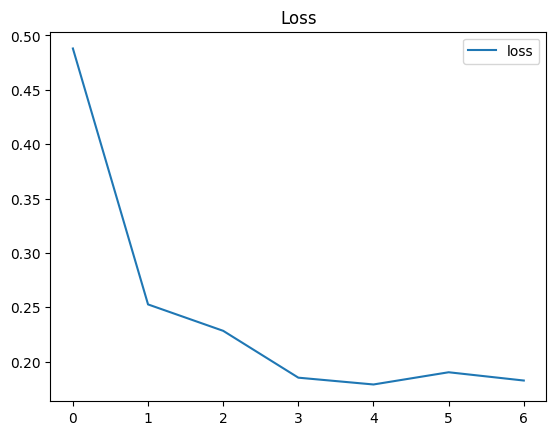

In [62]:
pd.DataFrame(history.history)[['accuracy']].plot()
plt.title("Accuracy")
plt.show()
pd.DataFrame(history.history)[['loss']].plot()
plt.title("Loss")
plt.show()

In [63]:
model.evaluate(test_images)

11/11 [==============================] - 42s 4s/step - loss: 1.7873 - accuracy: 0.0000e+00


[1.7873226404190063, 0.0]

In [64]:
model.save("tyre_condition_model_3.h5")

In [18]:
model = tf.keras.models.load_model('/content/drive/MyDrive/TyreConditionPrediction/tyre_condition_model.h5')

In [19]:
from tensorflow.keras.preprocessing import image

test_image = image.load_img('/content/drive/MyDrive/TyreConditionPrediction/tyre4_img.jpg', target_size = (224, 224)) # Get the image
transformed_image = image.img_to_array(test_image) # Transform image to array
transformed_image = np.expand_dims(transformed_image, axis=0) # Expand dims to make a batch of 1 image
prediction = model.predict(transformed_image)

if prediction[0][0] > 0.5:
  print("This tyre HAS a problem!")
else:
  print("This tyre HASN'T problem!")

1/1 [==============================] - 1s 1s/step
This tyre HASN'T problem!
